# Object-Oriented Programming: A Primer for Reinforcement Learning
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eleni-vasilaki/rl-notes/blob/main/notebooks/00_oop_primer.ipynb)

This primer introduces the object-oriented programming (OOP) techniques used throughout the reinforcement learning notebooks. The goal is not to present OOP as a set of templates to copy, but to develop the intuition for *when* and *why* these techniques help — and to prepare you for machine learning libraries used in research and industry, which are built on exactly the same ideas.

## The Reinforcement Learning Picture

The code examples in this primer are drawn from reinforcement learning (RL), so it helps to have the basic picture in mind before we start writing classes. You do not need to understand the maths — just the cast of characters.

Imagine training a dog. The dog is in a room. It can do things — sit, walk left, walk right. After it does something, you might give it a treat, or not. Over many repetitions, the dog figures out which actions lead to treats.

Reinforcement learning is this idea, made precise:

- The **environment** is the room — the world the learner lives in. It keeps track of the current situation (the **state**), and when the learner does something, the environment responds: it produces a new state and possibly a **reward** (the treat).
- The **agent** is the dog — the learner. It observes the current state, picks an **action**, and then updates its understanding of the world based on the reward it receives. Over time, it builds up **value estimates** — its own guess of how good each action is in each situation.
- The **policy** is the agent's strategy for choosing actions. "Always pick the action I think is best" is one policy. "Usually pick the best, but sometimes try something random" is another. The policy is a *rule*, not a separate entity — it describes *how* the agent decides.

One full run from start to finish — the dog enters the room, does things, and eventually reaches a goal or a time limit — is called an **episode**. Training typically involves many episodes: the agent gets better each time because it remembers what it learned in previous episodes.

The whole process is a loop:

```
state = environment.reset()                         # Start a new episode
while not done:
    action = agent.select_action(state)              # Agent picks an action
    state, reward, done = environment.step(action)   # Environment responds
    agent.update(state, action, reward)              # Agent learns from the reward
```

Notice that the environment tracks the state — including the agent's position in the world. This might seem odd (shouldn't the agent know where *it* is?), but it is a practical design choice: the environment is the single source of truth for everything about the world, and the agent receives that information through the values returned by `reset()` and `step()`. Think of a board game — the *board* tracks where all the pieces are; the player just decides which move to make. This is also the convention followed by popular RL libraries such as Gymnasium and Stable-Baselines3, so adopting it here means the patterns you learn will transfer directly if you use those tools later.

This loop is what every RL notebook in this course implements in one form or another. The purpose of OOP is to make this loop *readable* — each noun in the description becomes a class, each verb becomes a method.

## 1. Finding Classes in Your Problem

Look at the RL loop above. A useful rule of thumb for turning a description into code:

> **Nouns suggest classes. Verbs suggest methods.**

The nouns *agent* and *environment* are things with identity. They persist over time, they have properties (the agent has value estimates; the environment has a layout), and they do things (the agent selects; the environment transitions). These are natural candidates for classes.

Other nouns — *action*, *reward*, *state* — are simple values: an integer, a float, a tuple. They don't need to be classes; a plain number or array will do.

The *policy* is an interesting case. It is a rule, not an entity — "usually pick the best action, but sometimes explore." It *could* be a function. It *could* be a class. The right choice depends on how much structure you need, and we will revisit this question as the primer develops.

This distinction matters because it tells you where to invest your effort. A class is worth writing when something has **state that changes over time** and **operations that act on that state**. If something is just a value passed around, keep it simple.

## 2. The Key Question: "What Needs to Remember?"

The single most useful question when deciding whether to use a class is:

> **Does this thing need to remember something between one call and the next?**

Look at the RL loop again. The environment needs to remember the current state — it changes every step. The agent needs to remember its value estimates — they get updated after every reward. Both have *state* that persists and changes, so both benefit from being classes.

The policy, on the other hand, is a decision rule: "given the current value estimates, pick an action." It does not need to remember anything of its own — it just looks at what the agent currently knows and makes a choice. That could be a simple function. (In Section 6, we will see that it can also be useful to wrap decision rules in classes for code organisation, but the motivation there is structure, not memory.)

A sigmoid function is another clear case — it just transforms an input and returns an output:

```python
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
```

Similarly, a helper that splits data into train/test sets, or one that smooths a curve, is a pure transformation — no memory, no state, just input in and output out. Keep these as standalone functions.

**Rule of thumb:** if you can describe something entirely as "given *this*, return *that*" with no hidden memory, it is a function. If it also needs to *keep track of something* across calls, it is a class.

## 3. Anatomy of a Class

A class bundles together **data** (attributes) and **behaviour** (methods) into a single unit. Here is the general structure:

```python
class ClassName:
    """One-line description of what this class represents."""

    def __init__(self, ...):       # Constructor: runs once when you create an object
        self.attribute = ...       # Instance attribute: data stored on *this* object

    def some_method(self, ...):    # Method: a function that can read/modify the object's data
        ...
```

Three things to notice:

- **`__init__`** is the constructor. It runs automatically when you write `ClassName(...)`. Its job is to set up the object's initial state.
- **`self`** is how each object refers to itself. When you write `self.Q = np.zeros(k)`, you are storing an array *on this particular object*, not in some global variable. Two objects created from the same class have independent copies of their attributes.
- **Methods** are functions defined inside the class. They always receive `self` as their first argument, giving them access to the object's data.

Let us make this concrete with a simple example from reinforcement learning: a single arm of a multi-armed bandit.

In [6]:
import numpy as np

class BanditArm:
    """A single arm of a multi-armed bandit."""

    def __init__(self, true_mean):
        """
        Args:
            true_mean (float): The true expected reward of this arm.
        """
        self.true_mean = true_mean   # Stored on the object — this is state
        self.pull_count = 0          # Also state: tracks how often we pulled

    def pull(self):
        """Sample a reward (Gaussian noise around the true mean)."""
        self.pull_count += 1         # Modifying the object's own state
        return self.true_mean + np.random.randn()


# Create two independent arm objects from the same blueprint
arm_a = BanditArm(true_mean=1.0)
arm_b = BanditArm(true_mean=3.0)

# Each object tracks its own state independently
print(f"Pull arm A: reward = {arm_a.pull():.2f}  (pulled {arm_a.pull_count} time)")
print(f"Pull arm B: reward = {arm_b.pull():.2f}  (pulled {arm_b.pull_count} time)")
print(f"Pull arm A again: reward = {arm_a.pull():.2f}  (pulled {arm_a.pull_count} times)")
print(f"Arm B is unaffected: pulled {arm_b.pull_count} time")

Pull arm A: reward = -0.14  (pulled 1 time)
Pull arm B: reward = 2.70  (pulled 1 time)
Pull arm A again: reward = 2.13  (pulled 2 times)
Arm B is unaffected: pulled 1 time


Notice that pulling `arm_a` twice does not affect `arm_b` at all. Each object is its own independent bundle of data. This is **encapsulation**: the arm's internal bookkeeping (its pull count, its true mean) is packaged together with the operations that use it.

## 4. A Complete Example: Environment and Agent

In reinforcement learning, the two central nouns are the **environment** and the **agent**. Let us build both for a simple problem: a one-dimensional track where the agent must walk from the left end to the right end to receive a reward.

We will write two classes and connect them through **composition** — the agent stores a reference to the environment it operates in. This keeps responsibilities separate: the environment knows the rules of the world; the agent knows the learning algorithm. Neither needs to know how the other works internally.

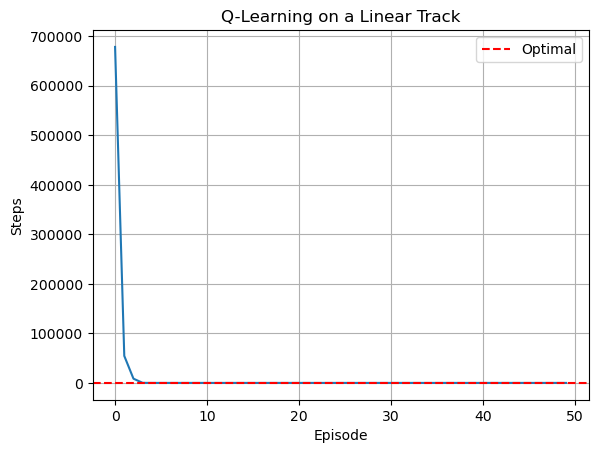

In [7]:
import numpy as np
import matplotlib.pyplot as plt


class LinearTrackEnv:
    """A one-dimensional corridor. The agent starts at state 0 and
    receives a reward of 1 upon reaching the far end."""

    def __init__(self, size):
        """
        Args:
            size (int): Number of states on the track.
        """
        self.size = size
        # The environment tracks the agent's position (see RL Picture above).
        self.state = 0

    def reset(self):
        """Place the agent back at the start. Returns the initial state."""
        self.state = 0
        return self.state

    def step(self, action):
        """Take one step.

        Args:
            action (int): 0 = move left, 1 = move right.

        Returns:
            tuple: (next_state, reward, done)
        """
        if action == 1:
            self.state = min(self.state + 1, self.size - 1)  # Clamp to right edge
        else:
            self.state = max(0, self.state - 1)              # Clamp to left edge

        done = (self.state == self.size - 1)
        reward = 1.0 if done else 0.0
        return self.state, reward, done


class QLearningAgent:
    """Tabular Q-learning agent for discrete environments."""

    def __init__(self, env, eta=0.1, gamma=0.99, epsilon=0.1):
        """
        Args:
            env (LinearTrackEnv): The environment to learn in.
            eta (float): Learning rate.
            gamma (float): Discount factor.
            epsilon (float): Exploration probability.
        """
        self.env = env                  # Composition: the agent *has* an environment
        self.eta = eta
        self.gamma = gamma
        self.epsilon = epsilon
        self.Q = np.zeros((env.size, 2))  # Q-table: one row per state, two actions

    def select_action(self, state):
        """Epsilon-greedy action selection."""
        if np.random.rand() < self.epsilon:
            return np.random.randint(2)
        else:
            return np.argmax(self.Q[state])

    def update(self, state, action, reward, next_state, done):
        """Apply the Q-learning update rule."""
        target = reward if done else reward + self.gamma * np.max(self.Q[next_state])
        self.Q[state, action] += self.eta * (target - self.Q[state, action])

    def run_episode(self):
        """Execute one complete episode. Returns the number of steps taken.

        Note: we place the episode loop on the agent here for convenience.
        Another valid design is to put this loop in a standalone function
        that receives both the agent and the environment as arguments.
        """
        state = self.env.reset()
        done = False
        steps = 0
        while not done:
            action = self.select_action(state)
            next_state, reward, done = self.env.step(action)
            self.update(state, action, reward, next_state, done)
            state = next_state
            steps += 1
        return steps


# --- Use the classes together ---
env = LinearTrackEnv(size=6)
agent = QLearningAgent(env, eta=0.5, gamma=0.9, epsilon=0.1)

steps_per_episode = []
for ep in range(50):
    steps = agent.run_episode()
    steps_per_episode.append(steps)

plt.plot(steps_per_episode)
plt.axhline(y=env.size - 1, color='r', linestyle='--', label='Optimal')
plt.xlabel('Episode')
plt.ylabel('Steps')
plt.title('Q-Learning on a Linear Track')
plt.legend()
plt.grid(True)
plt.show()

**What to notice:**

- The environment tracks the agent's position in `self.state`. This is the design choice introduced in the RL Picture section: the environment is the single source of truth for the world, and the agent learns about its situation through the values returned by `reset()` and `step()`.
- `QLearningAgent.__init__` stores `self.env = env`. This is **composition**: the agent *has* an environment. When the agent needs to take a step, it calls `self.env.step(action)`. The agent does not need to know how the environment implements `step` — only that the method exists and returns `(next_state, reward, done)`.
- The Q-table `self.Q` lives on the agent, because the agent is the thing that *remembers* value estimates.
- `run_episode` lives on the agent here for convenience, but this is a design choice. It could equally be a standalone function: `def run_episode(agent, env): ...`. Neither approach is wrong — what matters is that the responsibilities are clear. In the notebooks you will see both styles.

This Environment/Agent split is a pattern you will see in every notebook. It is also the standard structure used by popular RL libraries such as Gymnasium and Stable-Baselines3, so the patterns you practise here will transfer directly if you use those tools later.

## 5. When to Keep Things as Functions

Not everything should be a class. Here are some examples from the notebooks of things that are better left as standalone functions:

```python
def sigmoid(x):
    """No state needed — just a mathematical transformation."""
    return 1 / (1 + np.exp(-x))


def smooth_data(data, alpha=0.1):
    """Takes data in, returns smoothed data out. No memory between calls."""
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]
    for i in range(1, len(data)):
        smoothed[i] = (1 - alpha) * smoothed[i - 1] + alpha * data[i]
    return smoothed


def split_data(X, y, train_size=0.7):
    """Partitions arrays. A pure transformation, no state."""
    n = int(train_size * len(X))
    return X[:n], y[:n], X[n:], y[n:]
```

All three follow the same pattern: they take input, do something to it, and return output. They do not need to *remember* anything between calls. Wrapping these in a class would add complexity without any benefit.

**A practical test:** if you find yourself writing a class with only `__init__` and one other method, and `__init__` just stores the arguments, consider whether a plain function would be clearer.

## 6. Composition Revisited: Passing the Policy to the Agent

In Section 4, the `QLearningAgent` has its action-selection logic (epsilon-greedy) hard-coded inside `select_action`. If we wanted to try softmax selection instead, we would need to edit the agent class or write a new one.

A more flexible design uses the same idea as `self.env = env` — **composition** — but this time for the policy. The agent manages Q-values and learning; the policy is a separate object, passed in, that only knows how to pick an action given some values. We can swap policies without touching the agent.

Here we apply this to the bandit problem, using `BanditArm` from Section 3 as our environment.

In [8]:
import numpy as np
from typing import Any

class BanditArm:
    """A single arm of a multi-armed bandit.
       It is identical to the original BanditArm from section 3.
    """

    def __init__(self, true_mean):
        """
        Args:
            true_mean (float): The true expected reward of this arm.
        """
        self.true_mean = true_mean   # Stored on the object — this is state
        self.pull_count = 0          # Also state: tracks how often we pulled

    def pull(self):
        """Sample a reward (Gaussian noise around the true mean)."""
        self.pull_count += 1         # Modifying the object's own state
        return self.true_mean + np.random.randn()

class EpsilonGreedyPolicy:
    """Decision rule: usually pick the best, sometimes explore."""

    def __init__(self, epsilon):
        self.epsilon = epsilon

    def select_action(self, Q):
        """Given Q-values, return an action."""
        if np.random.rand() < self.epsilon:
            return np.random.randint(len(Q))
        return np.argmax(Q)

class SoftMaxPolicy:
    """Decision rule: sample actions proportional to estimated values."""

    def __init__(self, tau):
        self.tau = tau

    def select_action(self, Q):
        """Given Q-values, return an action."""
        exp_Q = np.exp(Q / self.tau)
        probs = exp_Q / np.sum(exp_Q)
        return np.random.choice(len(Q), p=probs)


class BanditAgent:
    """Agent for the multi-armed bandit problem.

    The agent tracks Q-values and learns from rewards.
    The action-selection policy is passed in as a component.
    """

    def __init__(self, arms, policy:Any, eta=0.1):
        """
        Args:
            arms (list): List of BanditArm objects (the environment).
            policy: An object with a select_action(Q) method.
            eta (float): Learning rate.
        """
        self.arms = arms
        self.policy = policy       # Composition: the agent *has* a policy
        self.eta = eta
        self.Q = np.zeros(len(arms))

    def run(self, steps):
        """Interact with the bandit for a number of steps."""
        for _ in range(steps):
            action = self.policy.select_action(self.Q)  # Delegate to the policy
            reward = self.arms[action].pull()            # Interact with the environment
            self.Q[action] += self.eta * (reward - self.Q[action])


# --- Set up the environment: three arms from Section 3 ---
arms_eg = [BanditArm(true_mean=1.0), BanditArm(true_mean=2.0), BanditArm(true_mean=3.0)]
arms_sm = [BanditArm(true_mean=1.0), BanditArm(true_mean=2.0), BanditArm(true_mean=3.0)]

# --- Same agent, different policies ---
agent_eg = BanditAgent(arms_eg, policy=EpsilonGreedyPolicy(epsilon=0.2), eta=0.1)
agent_sm = BanditAgent(arms_sm, policy=SoftMaxPolicy(tau=0.5), eta=0.1)

agent_eg.run(steps=200)
agent_sm.run(steps=200)

print(f"Epsilon-greedy Q-values: {agent_eg.Q.round(2)}")
print(f"Softmax Q-values:        {agent_sm.Q.round(2)}")

# We can even swap the policy on an existing agent
agent_eg.policy = SoftMaxPolicy(tau=1.0)
print(f"\nSwapped policy — agent now uses: {agent_eg.policy.__class__.__name__}") 
agent_eg.run(steps=200)
print(f"\nSoftmax Q-values: {agent_eg.Q.round(2)}")

Epsilon-greedy Q-values: [0.78 1.71 2.55]
Softmax Q-values:        [0.   0.52 2.76]

Swapped policy — agent now uses: SoftMaxPolicy

Softmax Q-values: [1.47 1.72 2.84]


**What to notice:**

- The policy classes are lightweight — they have no Q-values, no memory. They are decision rules: given Q-values, return an action. This matches what we said in Section 2: a policy does not need to remember anything.
- The agent stores `self.policy = policy`, just like it stores `self.env = env` in Section 4. Both are **composition**: the agent *has* a policy, the agent *has* an environment.
- We can swap policies without rewriting the agent. This is useful for experimenting — try epsilon-greedy, try softmax, compare results — all with the same agent and environment code.
- If we want to compare performance of the two agents, we should run longer experiments and observe statistical differences (mean performance, variance). This is best done in two identical but independent environments to avoid interference.

**For VS Code users:**

We import `Any` from `typing` and annotate policy as `Any` (`self.policy: Any = policy`) to avoid a false-positive Pylance type-checking warning. Pylance is the VS Code Python language engine that provides autocomplete and static analysis.

## 7. When Classes Share Behaviour: Inheritance

Sometimes you will write two classes and notice that large parts of them are identical. Inheritance lets you write the shared parts once in a **base class**, and then create **subclasses** that only specify what is different.

Here is a concrete example. In Section 3, we wrote a `BanditArm` that generates Gaussian rewards (the true mean plus random noise). But in later notebooks, we will encounter arms with different reward distributions — for instance, binary arms that pay out a fixed amount with some probability, or nothing otherwise.

Both types of arm need the same bookkeeping:

- Track how many times the arm has been pulled (`pull_count`)
- Accumulate total reward (`total_reward`)
- Compute a running average (`average_reward`)
- Reset all of this when starting fresh (`reset`)

The only thing that differs is *how they generate a reward*. Rather than writing two separate classes with most of the code duplicated, we can write the shared parts once in a base class and let each subclass define its own `_sample_reward` method.

In [9]:
import numpy as np
from typing import Any

class BaseBanditArm:  
    """Base class for bandit arms. 

    Handles pull counting, reward tracking, and averaging.
    Subclasses define how rewards are generated.
    """

    def __init__(self):
        self.pull_count = 0
        self.total_reward = 0.0

    def reset(self):
        """Reset all bookkeeping."""
        self.pull_count = 0
        self.total_reward = 0.0

    def pull(self):
        """Pull the arm: update bookkeeping and return a reward."""
        self.pull_count += 1
        reward = self._sample_reward()   # Defined by each subclass
        self.total_reward += reward
        return reward

    def average_reward(self):
        """Return the average reward observed so far."""
        if self.pull_count == 0:
            return 0.0
        return self.total_reward / self.pull_count

    def _sample_reward(self):
        """Generate a single reward. Subclasses must override this."""
        raise NotImplementedError("Subclasses define their reward distribution.")


class GaussianArm(BaseBanditArm):
    """Arm whose rewards are Gaussian: true_mean + noise."""

    def __init__(self, true_mean):
        super().__init__()           # Set up pull_count, total_reward
        self.true_mean = true_mean   # Add what makes this subclass different

    def _sample_reward(self):
        return self.true_mean + np.random.randn()


class BinaryArm(BaseBanditArm):
    """Arm that pays a fixed amount with some probability, or nothing."""

    def __init__(self, p_success, magnitude=1.0):
        super().__init__()
        self.p_success = p_success
        self.magnitude = magnitude

    def _sample_reward(self):
        return self.magnitude if np.random.rand() < self.p_success else 0.0


# --- Create a mixed bandit with different arm types ---
arms = [
    GaussianArm(true_mean=2.0),
    BinaryArm(p_success=0.3, magnitude=10.0),
    GaussianArm(true_mean=1.5),
]

# The agent from Section 6 works with any arm — it only calls pull()
class BanditAgent:
    """Agent for the multi-armed bandit problem.

    The agent tracks Q-values and learns from rewards.
    The action-selection policy is passed in as a component.
    """

    def __init__(self, arms, policy:Any, eta=0.1):
        """
        Args:
            arms (list): List of BanditArm objects (the environment).
            policy: An object with a select_action(Q) method.
            eta (float): Learning rate.
        """
        self.arms = arms
        self.policy = policy       # Composition: the agent *has* a policy
        self.eta = eta
        self.Q = np.zeros(len(arms))

    def run(self, steps):
        """Interact with the bandit for a number of steps."""
        for _ in range(steps):
            action = self.policy.select_action(self.Q)  # Delegate to the policy
            reward = self.arms[action].pull()            # Interact with the environment
            self.Q[action] += self.eta * (reward - self.Q[action])

# EpsilonGreedyPolicy from Section 6
class EpsilonGreedyPolicy:
    """Decision rule: usually pick the best, sometimes explore."""

    def __init__(self, epsilon):
        self.epsilon = epsilon

    def select_action(self, Q):
        """Given Q-values, return an action."""
        if np.random.rand() < self.epsilon:
            return np.random.randint(len(Q))
        return np.argmax(Q)

agent = BanditAgent(arms, policy=EpsilonGreedyPolicy(epsilon=0.1), eta=0.1)
agent.run(steps=500)

for i, arm in enumerate(arms):
    print(f"Arm {i} ({arm.__class__.__name__:12s}): "
          f"pulled {arm.pull_count:3d} times, "
          f"avg reward = {arm.average_reward():.2f}")
print(f"\nAgent Q-values: {agent.Q.round(2)}")

Arm 0 (GaussianArm ): pulled 436 times, avg reward = 1.98
Arm 1 (BinaryArm   ): pulled  47 times, avg reward = 2.13
Arm 2 (GaussianArm ): pulled  17 times, avg reward = 1.38

Agent Q-values: [2.17 1.32 1.05]


**How to think about inheritance:**

- Start by writing your classes *without* inheritance. If you notice that two classes have identical methods, that is a signal.
- Extract the shared code into a base class. The base class represents *what all variants have in common*.
- Each subclass adds only what makes it *different* — in this case, a different `_sample_reward` method.
- `super().__init__()` calls the base class constructor, which sets up the shared attributes (`pull_count`, `total_reward`). The subclass constructor then adds its own attributes (`true_mean`, or `p_success` and `magnitude`).
- `raise NotImplementedError` in the base class is a safety net: if someone creates a `BaseBanditArm()` directly and tries to call `pull()`, they get a clear error message instead of silent misbehaviour.

Notice that `pull()` in the base class calls `self._sample_reward()` — and Python automatically runs the version defined in the subclass. This means the base class can define the *structure* of an operation (update bookkeeping, then generate a reward) while leaving the *specifics* to each subclass. This pattern appears throughout machine learning libraries: for example, in PyTorch, the base class `nn.Module` defines the training infrastructure, and your subclass provides `forward()` — exactly the same idea as `BanditArm` providing `pull()` while subclasses provide `_sample_reward()`.

Also notice that the `BanditAgent` from Section 6 works with *any* arm type — Gaussian, binary, or a mix — because it only ever calls `pull()`. It does not need to know or care how the arm generates its rewards. This is one of the practical payoffs of inheritance: new arm types can be added without changing the agent at all.

**When to use inheritance vs. not:**

Inheritance is helpful when you have several classes that genuinely share a common interface and significant shared logic. It is *not* worth it when the shared code is just a line or two — in that case, a small amount of duplication is clearer than an inheritance hierarchy. In the notebooks, the simpler exercises use self-contained classes (no inheritance), while the more advanced solutions may use it where the shared logic is substantial.

## 8. Documenting Your Classes

Good documentation makes code readable months later. The convention used throughout the notebooks is:

```python
class SingleNeuronModel:
    """Single-layer neural model with sigmoid activation."""

    def __init__(self, input_dim, output_dim):
        """
        Args:
            input_dim (int): Number of input features.
            output_dim (int): Number of output units.
        """
        self.W = np.random.randn(input_dim, output_dim) * 0.01
        self.b = np.zeros(output_dim)

    def train(self, X, y_t, learning_rate, epochs):
        """Train the model using gradient descent on squared error loss.

        Args:
            X (ndarray): Input data, shape (batch_size, input_dim).
            y_t (ndarray): Target values, shape (batch_size, output_dim).
            learning_rate (float): Step size for parameter updates.
            epochs (int): Number of passes over the data.
        """
        ...
```

Each class has a one-line summary. Each method that takes non-obvious arguments has an `Args:` section listing them with types and brief descriptions. Methods that return something have a `Returns:` section. This is not busywork — it is how you communicate what a function expects and what it gives back.

## 9. Naming Conventions

Python uses a simple convention for method names:

- **`method_name`**: a normal method, part of the class's public interface. Other code is expected to call it.
- **`_method_name`** (single leading underscore): a *helper* method intended for internal use within the class. Other code *can* call it, but the underscore signals "this is an implementation detail, not part of the main interface."

Later in the course we will combine artificial neural networks with reinforcement learning to build more powerful agents. In those notebooks, you will see classes like this:

```python
class LinearTrackQAgent:

    def _one_hot(self, state):
        """Encode a state index as a one-hot vector. Internal helper."""
        x = np.zeros((1, self.states))
        x[0, state] = 1
        return x

    def select_action(self, state):
        """Select an action (public interface)."""
        X = self._one_hot(state)
        ...
```

The underscore on `_one_hot` tells the reader: "this is a utility used inside the class; you don't need to call it directly." It keeps the public interface clean — users of the class only need to think about `select_action`, `update_Q`, and `train`. If you understand the patterns in this notebook, you already understand how libraries like PyTorch — a key tool for modern machine learning — are structured (see Section 10).

## 10. From Here to Professional ML Libraries

Later in the course we will combine artificial neural networks with the reinforcement learning techniques you have already seen, producing agents that can handle much larger and more complex problems. The class `SingleNeuronModel` in the table below is a preview of those later notebooks — you do not need to understand its internals yet.

The reason we mention it here is that the OOP patterns you have just learnt are the same patterns used by professional machine learning libraries such as PyTorch. If you understand `__init__`, `self`, inheritance, and composition as covered in this notebook, you already understand how PyTorch is structured — and the transition to it will feel natural.

For example, here is how the patterns map onto PyTorch:

| Notebooks | PyTorch equivalent |
|---|---|
| `class SingleNeuronModel:` | `class MyModel(nn.Module):` |
| `def __init__(self, ...):` | `def __init__(self, ...):` |
| `self.W = np.random.randn(...) * 0.01` | `self.W = nn.Parameter(torch.randn(...) * 0.01)` |
| `def output(self, X):` | `def forward(self, X):` |
| `return self.activation(X @ self.W + self.b)` | `return torch.sigmoid(X @ self.W + self.b)` |

In PyTorch, `nn.Module` is a **base class** — exactly like the `BanditArm` base class in Section 7. Writing `class MyModel(nn.Module)` creates a subclass. Calling `super().__init__()` runs the base class constructor. Defining `forward()` overrides a method — just like overriding `select_action()`.

You do not need to know PyTorch for this course. The point is simply that getting comfortable with `__init__`, `self`, methods, and composition now means you are already learning the structure that these widely-used tools are built on.

## 11. Summary: A Decision Guide

When writing code for a new problem, ask yourself these questions in order:

**1. Does this thing need to remember something?**
- *No* → write a **function**.
- *Yes* → it should probably be a **class**. Continue to question 2.

**2. What are this object's responsibilities?**
- List the *data* it needs to store (→ attributes in `__init__`).
- List the *operations* it performs on that data (→ methods).
- If something doesn't need the object's data, it might belong as a standalone function instead.

**3. Am I writing two classes with a lot of identical code?**
- *No* → keep them as separate, self-contained classes. Simplicity wins.
- *Yes* → consider extracting the shared logic into a **base class** and using inheritance.

**4. Does one object need to *use* another?**
- Store a reference: `self.env = env`. This is **composition**. The two objects communicate through method calls (`self.env.step(action)`) rather than sharing internal state.

**5. Should a component be swappable?**
- Pass it in as an argument: `self.policy = policy`. This keeps your classes flexible — you can change behaviour without rewriting the class.

The techniques introduced here — classes, composition, inheritance, and the function/class distinction — cover everything you will encounter in the reinforcement learning notebooks and provide a foundation for working with modern machine learning libraries.

## Further Reading

- [Official Python Tutorial — Classes](https://docs.python.org/3/tutorial/classes.html): comprehensive reference for all class features in Python.
- [NumPy Documentation](https://numpy.org/doc/): reference for the array operations used throughout.
- [Gymnasium Documentation](https://gymnasium.farama.org/): the most widely used RL environment library — uses the same Environment class pattern as these notebooks.
- [PyTorch — What is `nn.Module`?](https://pytorch.org/docs/stable/generated/torch.nn.Module.html): for those interested in seeing how a major ML library builds on the OOP patterns covered here.